<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/renewautoencoderTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary
import skimage.util.noise as noise #Denoise 패키지인 Sckit.image의 util모듈. return 값은 numpy로 다루는 ndarray임. https://scikit-image.org/docs/stable/api/skimage.util.html#random-noise 


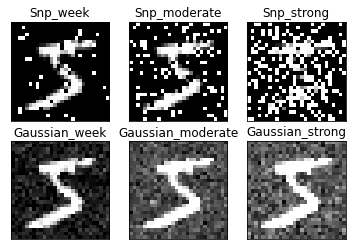

In [28]:
transform=transforms.ToTensor()
train_set = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_set = datasets.MNIST(root='./data',train=False,download=True,transform=transform)
num_workers=0 #?
batch_size = 50

train_set_arr=train_set.data.numpy() #numpy 자료형(ndarray) 변환.
test_set_arr=test_set.data.numpy()

Snp_train_set_arr1 = noise.random_noise(train_set_arr,mode='s&p',amount=0.1) #함수 random_noise를 사용한다. speckle도 추가 가능
Snp_train_set_arr2 = noise.random_noise(train_set_arr,mode='s&p',amount=0.3)
Snp_train_set_arr3 = noise.random_noise(train_set_arr,mode='s&p',amount=0.5)

Snp_test_set_arr1 = noise.random_noise(test_set_arr,mode='s&p',amount=0.1) 
Snp_test_set_arr2 = noise.random_noise(test_set_arr,mode='s&p',amount=0.3)
Snp_test_set_arr3 = noise.random_noise(test_set_arr,mode='s&p',amount=0.5)

Gn_train_set_arr1 = noise.random_noise(train_set_arr,mode='gaussian',mean=0.1) #gaussian,speckle noise의 비율을 결정하는 파라미터인 mean이다. default는 0이다.
Gn_train_set_arr2 = noise.random_noise(train_set_arr,mode='gaussian',mean=0.3)
Gn_train_set_arr3 = noise.random_noise(train_set_arr,mode='gaussian',mean=0.5)

Gn_test_set_arr1 = noise.random_noise(test_set_arr,mode='gaussian',mean=0.1) 
Gn_test_set_arr2 = noise.random_noise(test_set_arr,mode='gaussian',mean=0.3)
Gn_test_set_arr3 = noise.random_noise(test_set_arr,mode='gaussian',mean=0.5)


titles = ['Snp_week', 'Snp_moderate', 'Snp_strong', 'Gaussian_week', 
          'Gaussian_moderate', 'Gaussian_strong']
images = [ Snp_train_set_arr1[0], Snp_train_set_arr2[0], Snp_train_set_arr3[0],
          Gn_train_set_arr1[0], Gn_train_set_arr2[0], Gn_train_set_arr3[0]]

for i in range(6):
  plt.subplot(2,3,i+1), plt.imshow(images[i],cmap='gray')
  plt.title(titles[i])
  plt.xticks([]), plt.yticks([]) #xticks?

#torch.from_numpy(img).float().div(255.0).unsqueeze(0)로 해결 하였습니다. 감사 합니다.

Snp_week_train = torch.from_numpy(Snp_train_set_arr1).float().div(255.0).unsqueeze(0)
Snp_moderate_train = torch.from_numpy(Snp_train_set_arr2)
Snp_strong_train= torch.from_numpy(Snp_train_set_arr3)

Gaussian_week_train = torch.from_numpy(Gn_train_set_arr1)
Gaussian_moderate_train = torch.from_numpy(Gn_train_set_arr2)
Gaussian_strong_train = torch.from_numpy(Gn_train_set_arr3)

Snp_week_test = torch.from_numpy(Snp_test_set_arr1)
Snp_moderate_test = torch.from_numpy(Snp_test_set_arr2)
Snp_strong_test = torch.from_numpy(Snp_test_set_arr3)

Gaussian_week_test = torch.from_numpy(Gn_test_set_arr1)
Gaussian_moderate_test = torch.from_numpy(Gn_test_set_arr2)
Gaussian_strong_test = torch.from_numpy(Gn_test_set_arr3)


In [19]:
print(train_set_arr.shape)
print(test_set_arr.shape)

(60000, 28, 28)
(10000, 28, 28)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [12]:
Snp_week_train_loader = DataLoader(Snp_week_train,batch_size=batch_size,num_workers=num_workers)
Snp_week_test_loader = DataLoader(Snp_week_test,batch_size=batch_size,num_workers=num_workers)

Snp_moderate_train_loader = DataLoader(Snp_moderate_train,batch_size=batch_size,num_workers=num_workers)
Snp_moderate_test_loader = DataLoader(Snp_moderate_test,batch_size=batch_size,num_workers=num_workers)

Snp_strong_train_loader = DataLoader(Snp_strong_train,batch_size=batch_size,num_workers=num_workers)
Snp_strong_test_loader = DataLoader(Snp_strong_test,batch_size=batch_size,num_workers=num_workers)

In [2]:
#CNN_Denoise를 정의하기
#Conv2D(input_channel,Output_channel,filter_size,stride는 이동 간격(기본1), padding=1(image주변을 padding으로 둘러싸서 이미지 크기 키움. 사용안하는 0이 default임)
#Max_pooling으로 이미지의 대표 feature(최대,최소,평균)를 추출
class ConvDenoiser(nn.Module):
  def __init__(self):

    #Encoder layer
    super(ConvDenoiser, self).__init__()
    self.conv1 = nn.Conv2d(1,32,3, padding=1) #depth를 1에서 32로 변환, 필터 크기는 3X3. zero 패딩 사용하므로 이미지 크기는 8X8로 유지 된다.
    self.conv2 = nn.Conv2d(32,16,3, padding=1)  #depth를 32에서 16으로 줄이고 필터 크기는 3X3
    self.conv3 = nn.Conv2d(16,8,3, padding =1) #depth를 16에서 8로, 필터 크기는 3X3
    self.pool = nn.MaxPool2d(2,2) #필터 크기 2X2로 해서 이미지의 feature 추출함.

    #Decoder layer
    self.t_conv1 = nn.ConvTranspose2d(8,8,3,stride=2) #stride로 필터의 간격을 2로 늘려서 차원을 늘린다. 패딩 사용 하지 않으므로 7X7로 사이즈 줄어듦
    self.t_conv2 = nn.ConvTranspose2d(8,16,2,stride=2) #transpose layer가 뭐하는거지? conv2D와 동일한 개수를 써야 되나?
    self.t_conv3= nn.ConvTranspose2d(16,32,2,stride=2) #필터의 간격을 2로 늘리는 이유?
    self.conv_out = nn.Conv2d(32,1,3,padding=1) #depth32->1로 만든다. 패딩 사용해서 마지막은 8X8 사이즈로 만들어준다.


  def forward(self,x):
    ##encode##
    ##활성화 함수 relu를 사용해서 hidden_layer를 쌓는다. 
    x = F.relu(self.conv1(x)) #1단 히든레이어
    x = self.pool(x)
    x = F.relu(self.conv2(x)) #2단 히든레이어
    x = self.pool(x)
    x = F.relu(self.conv3(x)) #3단 히든레이어
    x = self.pool(x)
    #Compressed representaion이다.
    ##Decode##
    ##마찬가지로 hidden_layer를 만든다.
    x = F.relu(self.t_conv1(x)) #1단 히든레이어 
    x = F.relu(self.t_conv2(x)) 
    x = F.relu(self.t_conv3(x))
    x = F.sigmoid(self.conv_out(x)) #마지막에 sigmoid 쓰는 이유->마지막 출력 레이어는 0~1.0사이의 값을 사용함. 
    return x



In [10]:
#모델 구조 살펴보기
model=ConvDenoiser()
torchsummary.summary(model,(1, 28, 28),device='cuda')

RuntimeError: ignored

In [9]:
#학습 할 모델 설정
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [25]:
#model loss_function
#optimizer는 error(또는 loss)를 줄이는데 사용함. weight+=weight-n*dE/dw로 gradient 미세조정한다. n은 학습율,E는 에러율이다.E(w)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Gradient와 learning rate를 둘 다 고려해서 방향을 찾는 Adam optimizer를 사용한다.
n_epochs = 5

for epoch in range(1, n_epochs+1):
  #loss mornitor
  train_loss = 0.0
#model training
  for data in Snp_week_train_loader:
       img,_=data
       optimizer.zero_grad() #모든 최적화 된 변수(optimizer?)의 gradient를 clear한다. 

    #foward pass임. 노이즈 입력에 의한 모델 예측값을 출력한다.

       outputs = model(data)
    #caculate the loss
    #target은 원본이미지이다.
       loss = criterion(outputs,data) #MSELoss(input, target)로 오차를 구해낸다.
       loss.backward()  #자동 미분 진행한다.
       optimizer.step() #파라미터 업데이트함(최적화 한 걸음 실행하겠다) 
       train_loss += loss.item()*data.size(0) #images.size(0)가 뭔데?

   #평균적인 학습 통계를 출력하기
       train_loss = train_loss/len(Snp_week_train_loader)
       print('Epoch:{} \t Training Loss: {:.6f}'.format(epoch,train_loss)) #중괄호 사이로 format(문자열포멧팅함수)에서 지정한 값이 들어간다


RuntimeError: ignored

In [ ]:
#<torch.utils.data.dataloader.DataLoader object at 0x7f4121698e10>

In [ ]:
print(Snp_train_set_arr1.shape)
print(Snp_test_set_arr1.shape)

In [ ]:
Snp_week_train_loader
